<a href="https://colab.research.google.com/github/jhu-nanoenergy/VAE-models/blob/main/AE_framework_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Setup and Data Preparation

In [1]:
# Helpful tutorial / example links
# https://github.com/timbmg/VAE-CVAE-MNIST/blob/master/models.py
# https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/

In [2]:
#Basic Packages
import matplotlib.pyplot as plt
import scipy.io as spio
import scipy.stats as stat
import pandas as pd
import numpy as np
import statsmodels
import os
import random
import h5py
import sys

#PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import argparse
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torch.utils.checkpoint import checkpoint 
from torch import autograd

#Ray Tune for hyperparameters
!pip install -q -U ray
from functools import partial
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

#Troubleshooting / Memory
!pip install -q -U torchinfo
from torchinfo import summary
import gc
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" #leftover from debugging but generally useful to have for cuda device side assert errors




#Plots
plt.style.use('ggplot')
!pip install -q -U seaborn

     |████████████████████████████████| 52.7 MB 1.2 MB/s 
     |████████████████████████████████| 4.1 MB 67.1 MB/s 
     |████████████████████████████████| 225 kB 90.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


In [3]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [4]:
# # DEFINE HYPERPARAMETERS # #
# for defining data
half_data_num = 500 # amount of data to use from EACH int / ext dataset
bsize = 3 # batch size, careful about making bigger because can cause cuda error 

# for defining network
fv = [256, 256, 512, 1024, 2048] #Channels/Convolutions of Images
fv_inv = [1024, 512, 256] #Channels/Tranpose Convolutions of Latent Space
ks = 3 #kernel size
feat_size = 512 #Feature Space Size
latent_features = 20 # dimensionality of latent space

# for defining loss
alpha = 30 #how much to weight MSE loss
beta = 1/40 #how much to weight KLD

# for defining training 
epochs = 50 # number of epochs to train for
# lr = 1e-6 # learning rate of SGD optimizer
lr = 1e-2 # learning rate of SGD optimizer
w_d = 1e-5 # weight decay of SGD optimizer

In [5]:
int_data_all = spio.loadmat('/content/drive/MyDrive/Thon Group Master Folder/Sreyas/Photonic Crystals/Rockfish Training Data Gen/int_total_sqr_no_struct.mat', squeeze_me=True)
# ext_data_all = spio.loadmat('/content/drive/MyDrive/Thon Group Master Folder/Sreyas/Photonic Crystals/Rockfish Training Data Gen/ext_total_sqr_no_struct.mat', squeeze_me=True)
wavelengths = int_data_all['lambda']
wavelengths = np.delete(wavelengths,np.where(wavelengths==[0.5]))
wavelengths = np.delete(wavelengths,np.where(wavelengths==[1]))
wavelengths = np.transpose(np.tile(wavelengths,(3,1)))

spec_points = np.shape(wavelengths)[0] # number of points in the spectra
print(np.shape(wavelengths))

(219, 3)


In [6]:
# import data from hdf file
fname_mask = '/content/drive/MyDrive/Thon Group Master Folder/Sreyas/Photonic Crystals/Rockfish Training Data Gen/allData.h5'
hdf_file = h5py.File(fname_mask, "r")

# # Print statements for investigating data parameters
print(list(hdf_file.keys()))
dext_spectra = hdf_file['ext/maskCell'] 
dint_spectra = hdf_file['int/maskCell']
# combined = np.concatenate((dext_spectra[:11],dint_spectra[:11]), axis=0)
# print(np.shape(combined))

['ext', 'int']


In [7]:
class ImageDataset(Dataset):
  #hf is the hdf5 file object
  #datanum is the number of datapoints from EACH set that will be used in the model
    def __init__(self,  hf, datanum, transform= transforms.Compose([ transforms.ToTensor(), transforms.ConvertImageDtype(dtype=torch.float)])  ): #when try to do half, get weird error
        super(Dataset, self).__init__()
        dext_height = hf['ext/height'] # height values of ext data
        dint_height = hf['int/height'] # height values of int data
        dext_spectra = hf['ext/spectCell'] # spectra values of ext data
        dint_spectra = hf['int/spectCell'] # spectra values of int data

        # get data into correct format
        self.spectra = torch.from_numpy(np.concatenate((dext_spectra[:datanum], dint_spectra[:datanum]), axis=0)) # spectra
        self.heights = torch.from_numpy(np.concatenate((dext_height[:datanum],dint_height[:datanum]), axis=0)) # heights
        self.masks = np.concatenate((hf['ext/maskCell'][:datanum],hf['int/maskCell'][:datanum]), axis=0)  # masks
        self.sizes =  torch.from_numpy(np.concatenate((hf['ext/size'][:datanum],hf['int/size'][:datanum]), axis=0)) # could switch to sreyas size calculation instead, not sure
        ext_label = np.ones((np.shape(dext_height))) # 1 label for ext data
        int_label = np.zeros((np.shape(dint_height))) # 0 label for ext data
        self.labels = torch.from_numpy(np.concatenate( (ext_label, int_label), axis=0)) # combine labels
        self.transform = transform             

    def __len__(self):
        return len(self.sizes)

    # currently extracting image, spectra and height 
    def __getitem__(self, idx): 
        image = (self.masks[idx,:,:]) # input mask image
        spectra = (( self.spectra[idx] )) # spectra  
        if self.transform: 
            image = self.transform(image) 
        return image, spectra

In [8]:
# # Data preparation
full_dataset = ImageDataset(hdf_file, half_data_num )

# Define ratios of train, validation and testing data
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = int(0.1 * len(full_dataset))

# Use random split with seed
split_seed=42;
print("Split Seed is:", split_seed)
data_train, data_val, data_test = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(split_seed))


# Split data into random batches
train_dataloader = DataLoader(data_train, batch_size = bsize, shuffle=True)
test_dataloader = DataLoader(data_test, batch_size = bsize)
valid_dataloader = DataLoader(data_val, batch_size = bsize)

# clear some unnecessary variables
#del hdf_file, int_data_all
gc.collect()

Split Seed is: 42


52

#Encoder

In [ ]:
from re import X
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()

    # Feature Extraction Network
    self.enc1 = nn.Sequential( # Feature Extraction Network extraction_layers
            # Conv_1
            nn.Conv2d(1, fv[0], kernel_size=ks, stride=1, padding="same"),
            nn.BatchNorm2d(fv[0]),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            
            # Conv_2 + Pool_1
            nn.Conv2d(fv[0], fv[1], kernel_size=ks,  stride=1, padding="same"),
            nn.BatchNorm2d(fv[1]),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),     
            nn.MaxPool2d(2,2),

            # Conv_3 + Pool_2
            nn.Conv2d(fv[1], fv[2], kernel_size=ks,  stride=1, padding="same"),
            nn.BatchNorm2d(fv[2]),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.MaxPool2d(2,2),

            # Conv_4 + Pool_3
            nn.Conv2d(fv[2], fv[3], kernel_size=ks,  stride=1, padding="same"),
            nn.BatchNorm2d(fv[3]),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.MaxPool2d(2,2),
        )
    self.enc2 = nn.Sequential( # feature_layer of Feature Extraction Network
            nn.Linear(32*32*1024, feat_size), #reducing to feat_size
            nn.BatchNorm2d(1)
        )

    # # Prediction network
    self.pred1 = nn.Sequential( 
            nn.Linear(feat_size, feat_size),
            nn.BatchNorm2d(1),
            nn.Linear(feat_size, feat_size),
            nn.BatchNorm2d(1),
            nn.Linear(feat_size, spec_points*3)
        )


    # # Recognition network
    self.rec1 =  nn.Sequential( nn.Linear(feat_size+3*spec_points, feat_size),
                               nn.BatchNorm2d(1),
    )
    self.fc_mean = nn.Linear(feat_size, latent_features)
    self.fc_cov = nn.Linear(feat_size, latent_features)
    
  def forward(self, x):

    # # Run Feature Extraction Network
    # encoding
    # batch size usually equals int(torch.numel(x)/256/256), but the final batch in loader may be less than batch size
    x = (x.view(int(torch.numel(x)/256/256), 1, 256, 256)) # get x in format of 4D tensor for inputting into Conv layers 
    x = self.enc1(x)

    # get e in format of 4D tensor for inputting into Linear layer 
    e = x.view(int(torch.numel(x)/32/32/1024), 32*32*1024)     
    e = torch.unsqueeze(e,1)
    e = torch.unsqueeze(e,1)    
    e = self.enc2(e) # run linear layer

    # # Run Prediction Network
    p = torch.sigmoid(self.pred1(e)) # p = predicted spectra

    # # Run Recognition Network
    input_rec = torch.cat((e,p), 3) # Combine condensed geometry features with the predicted spectra    
    x = self.rec1(input_rec)
    mu = self.fc_mean(x)
    log_var = self.fc_cov(x)

    return p, mu, log_var 

#Decoder

In [ ]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.recog = nn.Sequential(
          #Fc_4 Fc_5 Fc_6
          nn.Linear(latent_features+3*spec_points, feat_size),
          nn.BatchNorm2d(1),
          nn.Linear(feat_size, feat_size),
          nn.BatchNorm2d(1),
          nn.Linear(feat_size, 32*32*fv_inv[0]),
          nn.BatchNorm2d(1),
        )

    self.reconstruct = nn.Sequential(
          nn.ConvTranspose2d(fv_inv[0], fv_inv[1], 3, stride=2, padding = 1, output_padding=1),
          nn.ConvTranspose2d(fv_inv[1], fv_inv[2], 3, stride=2, padding = 1, output_padding=1),
          nn.ConvTranspose2d(fv_inv[2], 1, 3, stride=2, padding = 1, output_padding=1)
        )


  def forward(self, spectra, latent):
    input_dec = torch.cat((spectra,latent),3) # combine spectra output with latent space output
    x = self.recog(input_dec) # run recognition layer
    x = x.view(int(torch.numel(x)/32/32/fv_inv[0]), fv_inv[0], 32, 32) # ensure the 4D tensor is the correct size
    x = self.reconstruct(x) # run reconstruction layer
    reconstruction =  torch.sigmoid( x )
    return reconstruction # output geometry based on spectra and latent space

# VAE Model(includes reparameterization)

In [ ]:
# primary VAE module

class CustomVAE(nn.Module):
    def __init__(self):
        super(CustomVAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample

    def forward(self, x):      
        x = self.encoder(x)  
        spectra, mu, log_var  = x        

        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        recon_x = self.decoder( spectra, z )
        recon_x = recon_x.view(int(torch.numel(recon_x)/256/256), 256, 256) # reconstructed geometry
        return recon_x, mu, log_var, spectra

    # TO DO: DEFINE SPECTRA PREDICTION FUNCTION AND GEOMETRY GENERATION


:# Training and Validation Functions

In [ ]:
# combined loss function that guides the entire network's training
def final_loss(loss1_bce, loss2_mse, mu, logvar):
    # mu: the mean from the latent vector
    # logvar: log variance from the latent vector
    
    
    # KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # previous KLD definition

    KLD = (-0.5 * torch.sum( 1 + 2*logvar - mu.pow(2) - (2*logvar).exp() ))/latent_features # better KLD definition


    return (loss1_bce + alpha*loss2_mse + beta*KLD)

In [ ]:
# fit function for training the model
def fit(model, dataloader):
    model.train() 
    running_loss = 0.0
    bce_losses = 0.0
    mse_losses = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_dataloader)/dataloader.batch_size)):
      if torch.cuda.is_available():
        # with autograd.detect_anomaly(): # uncomment this to debug when you receive "Cuda: device-side assert error"  
          
          data, spectra_in = [d.cuda( ) for d in data] # load in data from data loader
          data = data.view(int(torch.numel(data)/256/256),  256, 256) # resize data for loss function later
          optimizer.zero_grad() # initialize gradients to zero

          reconstruction, mu, logvar, out_spectra = model(data) # run model
          pout = out_spectra.view(-1, 3, spec_points)  # reformat spectra for plotting
          
          # leftover code from when i was trying to debug NAN error, potentially unnecessary
          reconstruction = reconstruction.clamp(0,1) # clamp between 0 and 1
          reconstruction[reconstruction!=reconstruction] = 1 # set NAN values  

          # solve for loss
          bce_loss = criterion_mask(reconstruction, data) 
          mse_loss = criterion(spectra_in.float(), pout)      
          loss = final_loss(bce_loss, mse_loss, mu, logvar)
          # add losses to overall loss "counters"
          running_loss += loss.item()          
          bce_losses += bce_loss.item()
          mse_losses += mse_loss.item()

          # backpropagate loss and then step the optimizer
          loss.backward()
          optimizer.step()

    print(f"Train BCE Loss: {bce_losses:.4f}")
    print(f"Train MSE Loss: {mse_losses:.4f}")
    train_loss = running_loss
    return train_loss, bce_losses, mse_losses
    


In [ ]:
# validate function for testing the model on the validation data

def validate(model, dataloader, plot_on):
  model.eval()
  running_loss = 0.0
  with torch.no_grad(): # all gradients off because currently just evaluating the model
    for i, data in tqdm(enumerate(dataloader), total=int(len(valid_dataloader)/dataloader.batch_size)):
        data, spectra_in = [d.cuda( ) for d in data] # load in data from data loader
        len_temp = int(torch.numel(data)/256/256) # usually this is batch size, but sometimes last batch is a different size
        data = data.view(len_temp,  256, 256) # resize data for loss function later

        reconstruction, mu, logvar, out_spectra = model(data) # run model
        pout = out_spectra.view(-1, 3, spec_points) #reformat spectra for plotting

        # leftover code from when i was trying to debug NAN error, potentially unnecessary
        reconstruction = reconstruction.clamp(0,1) # clamp between 0 and 1
        reconstruction[reconstruction!=reconstruction] = 1 # set NAN values  
        
        # solve for loss
        bce_loss = criterion_mask(reconstruction, data) 
        mse_loss = criterion(spectra_in.float(), pout) 
        loss = final_loss(bce_loss, mse_loss, mu, logvar)
        running_loss += loss.item()

        # save and plot the last batch input and output 
        if plot_on:
          if i == len_temp - 1:
            # first plot shows input geometry vs output geometry
            num_replicas = 4
            fig, axs = plt.subplots(2,num_replicas)
            for x in range( num_replicas ):      
              axs[0,x].imshow(torch.squeeze(data.view(len_temp, 1, 256, 256)[x]).cpu())
              axs[0,x].xaxis.set_visible(False)
              axs[0,x].yaxis.set_visible(False)
              axs[1,x].imshow(torch.squeeze(reconstruction.view(len_temp, 1, 256, 256)[x]).cpu())
              axs[1,x].xaxis.set_visible(False)
              axs[1,x].yaxis.set_visible(False)
            fig.suptitle(str(epoch+1))

            # second plot shows input spectra vs output spectra
            og = spectra_in[0].detach().cpu().numpy()
            pred = pout[0].detach().cpu().numpy()
            
            fig2, axs = plt.subplots(2,1)
            axs[0].plot(wavelengths, np.transpose(og) )
            axs[1].plot(wavelengths, np.transpose(pred) )
            fig2.suptitle(str(epoch+1))

            # save figures
            fig.savefig(f"/content/drive/MyDrive/Thon Group Master Folder/Serene/Spectral Selectivity Project/outputs/{epoch+1}geom_output.png")
            fig2.savefig(f"/content/drive/MyDrive/Thon Group Master Folder/Serene/Spectral Selectivity Project/outputs/{epoch+1}spectra_output.png")
            plt.show()
            
    # val_loss = running_loss/len(dataloader.dataset)
    val_loss = running_loss
    return val_loss

# Model Training

In [ ]:
model_custom = CustomVAE().cuda() # send model architecture to cuda
print(summary(model_custom, input_size = (bsize,1,256,256))) # print model summary
optimizer = optim.SGD(model_custom.parameters(), lr=lr, weight_decay = w_d) #use SGD optimizer to mimic paper
criterion_mask = nn.BCELoss(reduction='mean') # use BCE loss for mask / geometry criterion, use 'mean' reduction so it is not too large
criterion = nn.MSELoss(reduction='mean') # use MSE loss for spectra criterion

Layer (type:depth-idx)                   Output Shape              Param #
CustomVAE                                --                        --
├─Encoder: 1-1                           [6, 1, 1, 657]            --
│    └─Sequential: 2-1                   [6, 1024, 32, 32]         --
│    │    └─Conv2d: 3-1                  [6, 256, 256, 256]        2,560
│    │    └─BatchNorm2d: 3-2             [6, 256, 256, 256]        512
│    │    └─LeakyReLU: 3-3               [6, 256, 256, 256]        --
│    │    └─Conv2d: 3-4                  [6, 256, 256, 256]        590,080
│    │    └─BatchNorm2d: 3-5             [6, 256, 256, 256]        512
│    │    └─LeakyReLU: 3-6               [6, 256, 256, 256]        --
│    │    └─MaxPool2d: 3-7               [6, 256, 128, 128]        --
│    │    └─Conv2d: 3-8                  [6, 512, 128, 128]        1,180,160
│    │    └─BatchNorm2d: 3-9             [6, 512, 128, 128]        1,024
│    │    └─LeakyReLU: 3-10              [6, 512, 128, 128]      

In [ ]:
# check that cuda is at acceptable limits
torch.cuda.synchronize()
torch.cuda.empty_cache()
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    4155 MB |    4931 MB |    7036 MB |    2881 MB |
|       from large pool |    4152 MB |    4927 MB |    7033 MB |    2881 MB |
|       from small pool |       3 MB |       3 MB |       3 MB |       0 MB |
|---------------------------------------------------------------------------|
| Active memory         |    4155 MB |    4931 MB |    7036 MB |    2881 MB |
|       from large pool |    4152 MB |    4927 MB |    7033 MB |

Epoch 1 of 50


350it [01:41,  3.45it/s]


Train BCE Loss: 256.0900
Train MSE Loss: 8.1986


 31%|███▏      | 5/16 [00:00<00:01,  9.62it/s]

MSE loss: tensor(0.0256, device='cuda:0')


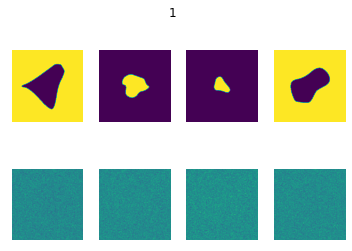

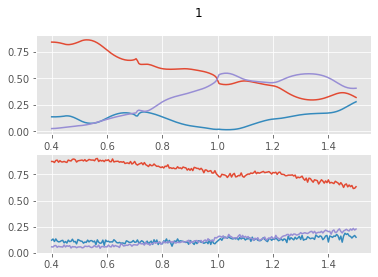

100it [00:10,  9.12it/s]


Train Loss: 502.9285
Val Loss: 114.5151
Epoch 2 of 50


350it [01:41,  3.45it/s]


Train BCE Loss: 247.2895
Train MSE Loss: 4.4424


100it [00:10,  9.67it/s]


Train Loss: 380.7495
Val Loss: 113.5046
Epoch 3 of 50


350it [01:41,  3.44it/s]


Train BCE Loss: 244.0969
Train MSE Loss: 3.9775


100it [00:10,  9.67it/s]


Train Loss: 363.5619
Val Loss: 106.4556
Epoch 4 of 50


350it [01:41,  3.44it/s]


Train BCE Loss: 241.4343
Train MSE Loss: 3.6530


100it [00:10,  9.65it/s]


Train Loss: 351.1504
Val Loss: 106.7854
Epoch 5 of 50


350it [01:41,  3.44it/s]


Train BCE Loss: 234.0116
Train MSE Loss: 3.3475


 31%|███▏      | 5/16 [00:00<00:01,  9.60it/s]

MSE loss: tensor(0.0222, device='cuda:0')


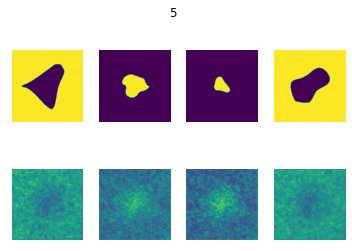

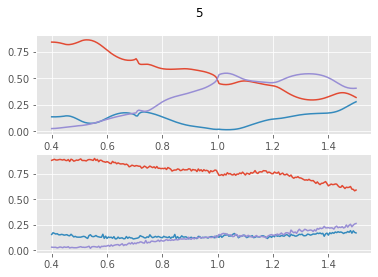

100it [00:11,  8.57it/s]


Train Loss: 334.6249
Val Loss: 106.7274
Epoch 6 of 50


350it [01:41,  3.44it/s]


Train BCE Loss: 190.5486
Train MSE Loss: 3.2147


100it [00:10,  9.68it/s]


Train Loss: 288.6139
Val Loss: 79.2657
Epoch 7 of 50


350it [01:41,  3.44it/s]


Train BCE Loss: 124.0288
Train MSE Loss: 2.8112


100it [00:10,  9.62it/s]


Train Loss: 213.8959
Val Loss: 72.9247
Epoch 8 of 50


350it [01:41,  3.43it/s]


Train BCE Loss: 100.1706
Train MSE Loss: 2.5900


100it [00:10,  9.67it/s]


Train Loss: 183.8563
Val Loss: 66.9788
Epoch 9 of 50


350it [01:41,  3.44it/s]


Train BCE Loss: 85.6036
Train MSE Loss: 2.2945


100it [00:10,  9.57it/s]


Train Loss: 161.1941
Val Loss: 66.8571
Epoch 10 of 50


350it [01:42,  3.43it/s]


Train BCE Loss: 79.1658
Train MSE Loss: 1.9876


 31%|███▏      | 5/16 [00:00<00:01,  9.64it/s]

MSE loss: tensor(0.0233, device='cuda:0')


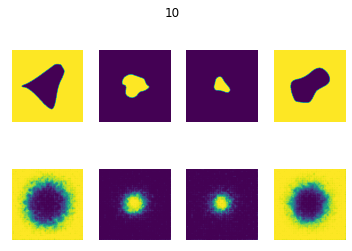

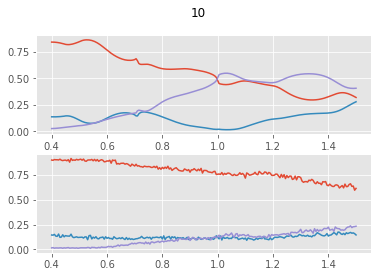

100it [00:11,  8.50it/s]


Train Loss: 144.8117
Val Loss: 66.8103
Epoch 11 of 50


350it [01:42,  3.43it/s]


Train BCE Loss: 76.2787
Train MSE Loss: 1.6839


100it [00:10,  9.64it/s]


Train Loss: 132.2899
Val Loss: 64.4650
Epoch 12 of 50


350it [01:42,  3.42it/s]


Train BCE Loss: 74.2046
Train MSE Loss: 1.6109


100it [00:10,  9.57it/s]


Train Loss: 127.8033
Val Loss: 67.7487
Epoch 13 of 50


350it [01:42,  3.42it/s]


Train BCE Loss: 72.2052
Train MSE Loss: 1.3610


100it [00:10,  9.62it/s]


Train Loss: 118.4690
Val Loss: 63.3386
Epoch 14 of 50


350it [01:42,  3.42it/s]


Train BCE Loss: 69.8862
Train MSE Loss: 1.2224


100it [00:10,  9.63it/s]


Train Loss: 111.4381
Val Loss: 63.1771
Epoch 15 of 50


350it [01:42,  3.42it/s]


Train BCE Loss: 67.3927
Train MSE Loss: 1.1000


 31%|███▏      | 5/16 [00:00<00:01,  9.63it/s]

MSE loss: tensor(0.0152, device='cuda:0')


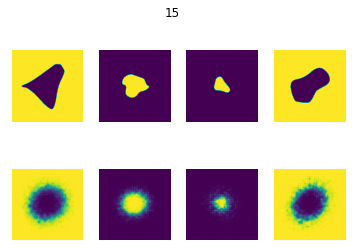

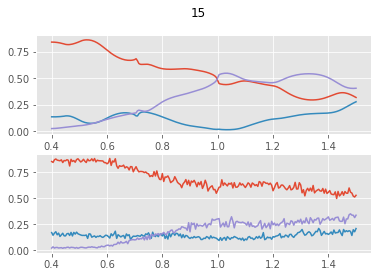

100it [00:11,  8.41it/s]


Train Loss: 105.4841
Val Loss: 65.6332
Epoch 16 of 50


350it [01:41,  3.43it/s]


Train BCE Loss: 64.2809
Train MSE Loss: 1.0101


100it [00:10,  9.65it/s]


Train Loss: 99.7764
Val Loss: 60.9324
Epoch 17 of 50


350it [01:42,  3.43it/s]


Train BCE Loss: 61.9267
Train MSE Loss: 0.9390


100it [00:10,  9.64it/s]


Train Loss: 95.5963
Val Loss: 60.7223
Epoch 18 of 50


350it [01:42,  3.43it/s]


Train BCE Loss: 60.4584
Train MSE Loss: 0.9010


100it [00:10,  9.64it/s]


Train Loss: 93.2014
Val Loss: 62.2163
Epoch 19 of 50


350it [01:42,  3.43it/s]


Train BCE Loss: 58.1273
Train MSE Loss: 0.8034


100it [00:10,  9.65it/s]


Train Loss: 88.1531
Val Loss: 59.8141
Epoch 20 of 50


350it [01:41,  3.43it/s]


Train BCE Loss: 57.0534
Train MSE Loss: 0.7574


 31%|███▏      | 5/16 [00:00<00:01,  9.61it/s]

MSE loss: tensor(0.0186, device='cuda:0')


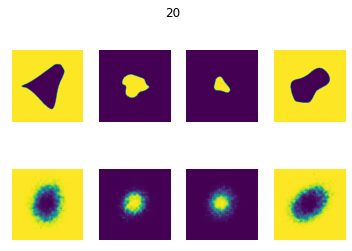

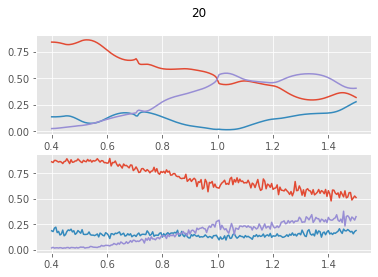

100it [00:11,  8.55it/s]


Train Loss: 85.8109
Val Loss: 60.9076
Epoch 21 of 50


350it [01:41,  3.43it/s]


Train BCE Loss: 55.4350
Train MSE Loss: 0.7275


100it [00:10,  9.64it/s]


Train Loss: 82.7701
Val Loss: 59.4964
Epoch 22 of 50


350it [01:42,  3.43it/s]


Train BCE Loss: 54.6637
Train MSE Loss: 0.7131


100it [00:10,  9.62it/s]


Train Loss: 81.3938
Val Loss: 61.3381
Epoch 23 of 50


350it [01:41,  3.43it/s]


Train BCE Loss: 52.9280
Train MSE Loss: 0.6693


100it [00:10,  9.65it/s]


Train Loss: 77.8458
Val Loss: 58.4338
Epoch 24 of 50


350it [01:41,  3.43it/s]


Train BCE Loss: 52.0344
Train MSE Loss: 0.6565


100it [00:10,  9.63it/s]


Train Loss: 76.0046
Val Loss: 58.2990
Epoch 25 of 50


350it [01:41,  3.43it/s]


Train BCE Loss: 51.1470
Train MSE Loss: 0.6603


 31%|███▏      | 5/16 [00:00<00:01,  9.59it/s]

MSE loss: tensor(0.0182, device='cuda:0')


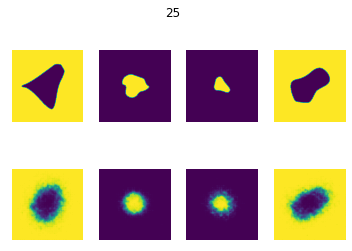

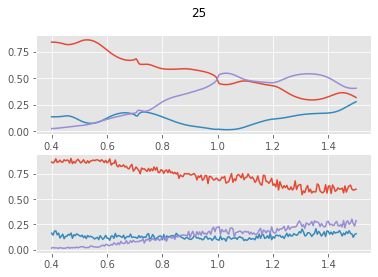

100it [00:11,  8.56it/s]


Train Loss: 74.5743
Val Loss: 58.9226
Epoch 26 of 50


350it [01:41,  3.43it/s]


Train BCE Loss: 49.8259
Train MSE Loss: 0.6720


100it [00:10,  9.65it/s]


Train Loss: 72.9728
Val Loss: 58.4697
Epoch 27 of 50


350it [01:42,  3.43it/s]


Train BCE Loss: 48.6810
Train MSE Loss: 0.6433


100it [00:10,  9.60it/s]


Train Loss: 70.3588
Val Loss: 68.0499
Epoch 28 of 50


350it [01:42,  3.43it/s]


Train BCE Loss: 51.8579
Train MSE Loss: 0.9553


100it [00:10,  9.64it/s]


Train Loss: 82.5897
Val Loss: 59.3288
Epoch 29 of 50


350it [01:42,  3.43it/s]


Train BCE Loss: 46.9057
Train MSE Loss: 0.6848


100it [00:10,  9.66it/s]


Train Loss: 68.9333
Val Loss: 57.1315
Epoch 30 of 50


350it [01:42,  3.43it/s]


Train BCE Loss: 45.5183
Train MSE Loss: 0.6367


 31%|███▏      | 5/16 [00:00<00:01,  9.58it/s]

MSE loss: tensor(0.0177, device='cuda:0')


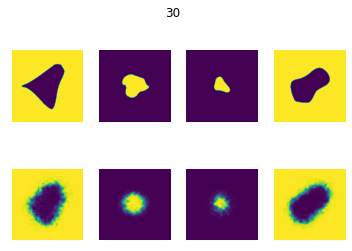

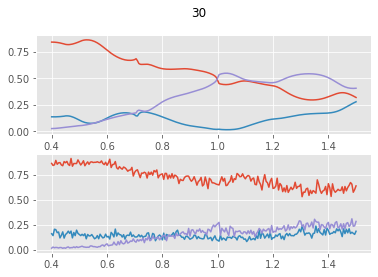

100it [00:11,  8.45it/s]


Train Loss: 65.8653
Val Loss: 57.2275
Epoch 31 of 50


350it [01:41,  3.43it/s]


Train BCE Loss: 43.7690
Train MSE Loss: 0.6225


100it [00:10,  9.63it/s]


Train Loss: 63.4880
Val Loss: 63.6267
Epoch 32 of 50


350it [01:41,  3.43it/s]


Train BCE Loss: 42.5676
Train MSE Loss: 0.5925


100it [00:10,  9.64it/s]


Train Loss: 61.2218
Val Loss: 56.1949
Epoch 33 of 50


350it [01:42,  3.43it/s]


Train BCE Loss: 42.2149
Train MSE Loss: 0.6535


100it [00:10,  9.65it/s]


Train Loss: 62.5548
Val Loss: 56.1221
Epoch 34 of 50


350it [01:42,  3.43it/s]


Train BCE Loss: 40.9937
Train MSE Loss: 0.6047


100it [00:10,  9.64it/s]


Train Loss: 59.7642
Val Loss: 55.6460
Epoch 35 of 50


350it [01:42,  3.43it/s]


Train BCE Loss: 39.1193
Train MSE Loss: 0.5700


 31%|███▏      | 5/16 [00:00<00:01,  9.64it/s]

MSE loss: tensor(0.0162, device='cuda:0')


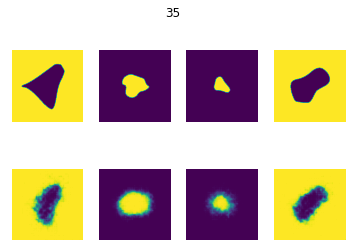

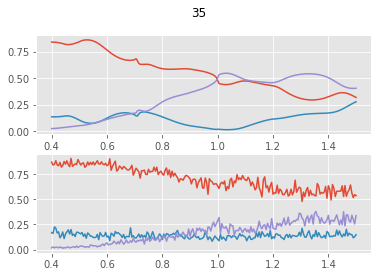

100it [00:11,  8.43it/s]


Train Loss: 56.7666
Val Loss: 61.9835
Epoch 36 of 50


350it [01:41,  3.43it/s]


Train BCE Loss: 37.6579
Train MSE Loss: 0.5552


100it [00:10,  9.63it/s]


Train Loss: 54.8036
Val Loss: 55.2248
Epoch 37 of 50


350it [01:42,  3.43it/s]


Train BCE Loss: 37.6864
Train MSE Loss: 0.5781


100it [00:10,  9.61it/s]


Train Loss: 55.4764
Val Loss: 54.9434
Epoch 38 of 50


350it [01:42,  3.43it/s]


Train BCE Loss: 36.4319
Train MSE Loss: 0.5465


100it [00:10,  9.64it/s]


Train Loss: 53.2206
Val Loss: 56.6747
Epoch 39 of 50


350it [01:42,  3.43it/s]


Train BCE Loss: 35.0619
Train MSE Loss: 0.5423


100it [00:10,  9.62it/s]


Train Loss: 51.6897
Val Loss: 54.7543
Epoch 40 of 50


350it [01:42,  3.43it/s]


Train BCE Loss: 35.2349
Train MSE Loss: 0.5880


 31%|███▏      | 5/16 [00:00<00:01,  9.59it/s]

MSE loss: tensor(0.0165, device='cuda:0')


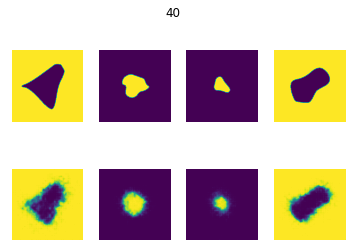

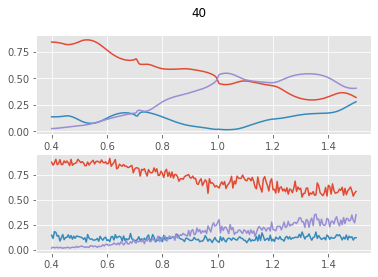

100it [00:11,  8.52it/s]


Train Loss: 53.2011
Val Loss: 55.0506
Epoch 41 of 50


350it [01:42,  3.43it/s]


Train BCE Loss: 34.2070
Train MSE Loss: 0.5427


100it [00:10,  9.61it/s]


Train Loss: 50.7742
Val Loss: 55.1936
Epoch 42 of 50


350it [01:42,  3.43it/s]


Train BCE Loss: 34.1750
Train MSE Loss: 0.5633


100it [00:10,  9.64it/s]


Train Loss: 51.3444
Val Loss: 54.5655
Epoch 43 of 50


350it [01:42,  3.43it/s]


Train BCE Loss: 30.9868
Train MSE Loss: 0.5224


100it [00:10,  9.61it/s]


Train Loss: 46.9020
Val Loss: 54.0420
Epoch 44 of 50


350it [01:42,  3.43it/s]


Train BCE Loss: 31.0125
Train MSE Loss: 0.5031


100it [00:10,  9.62it/s]


Train Loss: 46.3359
Val Loss: 61.3053
Epoch 45 of 50


350it [01:42,  3.43it/s]


Train BCE Loss: 30.6805
Train MSE Loss: 0.5106


 31%|███▏      | 5/16 [00:00<00:01,  9.57it/s]

MSE loss: tensor(0.0177, device='cuda:0')


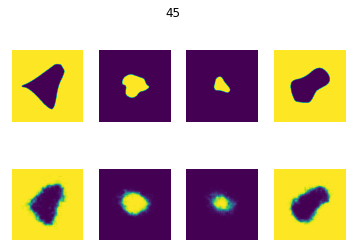

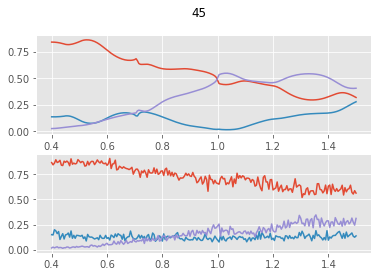

100it [00:11,  8.49it/s]


Train Loss: 46.2164
Val Loss: 54.5593
Epoch 46 of 50


350it [01:42,  3.43it/s]


Train BCE Loss: 30.3003
Train MSE Loss: 0.5117


100it [00:10,  9.66it/s]


Train Loss: 45.8527
Val Loss: 54.1898
Epoch 47 of 50


350it [01:42,  3.43it/s]


Train BCE Loss: 29.0688
Train MSE Loss: 0.4847


100it [00:10,  9.63it/s]


Train Loss: 43.7983
Val Loss: 54.5844
Epoch 48 of 50


350it [01:42,  3.43it/s]


Train BCE Loss: 28.5250
Train MSE Loss: 0.4747


100it [00:10,  9.64it/s]


Train Loss: 42.9429
Val Loss: 54.4160
Epoch 49 of 50


350it [01:42,  3.43it/s]


Train BCE Loss: 28.6308
Train MSE Loss: 0.4894


100it [00:10,  9.63it/s]


Train Loss: 43.4857
Val Loss: 53.6924
Epoch 50 of 50


350it [01:42,  3.43it/s]


Train BCE Loss: 27.4523
Train MSE Loss: 0.4771


 31%|███▏      | 5/16 [00:00<00:01,  9.64it/s]

MSE loss: tensor(0.0188, device='cuda:0')


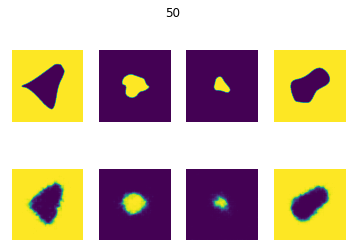

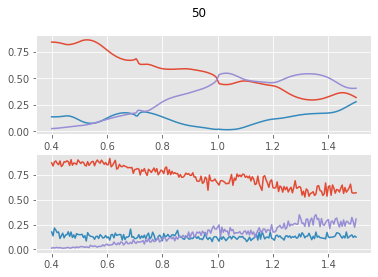

100it [00:11,  8.47it/s]

Train Loss: 41.9293
Val Loss: 53.7103


In [ ]:
# # Loop over epochs

# keep track of different losses
train_loss = []
val_loss = []
train_bce_loss = []
train_mse_loss = []
train_kld_loss=[]
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    
    # empty cuda cache to help prevent unneeded memory usage
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
    
    # fit data
    train_epoch_loss, train_epoch_bce, train_epoch_mse = fit(model_custom, train_dataloader) 

    # test on validation data
    if epoch == 0 or not ((epoch+1) % 5): # plot output every 5 epochs
      val_epoch_loss = validate(model_custom, valid_dataloader, 1)
    else: # determine validation loss without plotting
      val_epoch_loss = validate(model_custom, valid_dataloader, 0)
    
    # add to variables
    train_loss.append(train_epoch_loss)
    train_bce_loss.append(train_epoch_bce)
    train_mse_loss.append(alpha*train_epoch_mse)
    train_kld_loss.append((train_epoch_loss - train_epoch_bce-alpha*train_epoch_mse))
    val_loss.append(val_epoch_loss)

    # print progress
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

In [ ]:
# print post summary of GPU usage
!nvidia-smi

Fri Mar 25 06:29:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    56W / 300W |  14929MiB / 16160MiB |     83%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

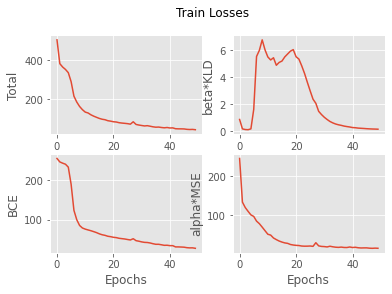

In [ ]:
# Plot different train losses
x = range(len(train_loss))
fig_losses, axs = plt.subplots(2,2)
axs[0,0].plot(x, train_loss )
axs[0,0].set_xlabel("Epochs")
axs[0,0].set_ylabel("Total")
axs[0,1].plot(x, train_kld_loss)
axs[0,1].set_xlabel("Epochs")
axs[0,1].set_ylabel("beta*KLD")
axs[1,0].plot(x, train_bce_loss)
axs[1,0].set_xlabel("Epochs")
axs[1,0].set_ylabel("BCE")
axs[1,1].plot(x, train_mse_loss)
axs[1,1].set_xlabel("Epochs")
axs[1,1].set_ylabel("alpha*MSE")

fig_losses.suptitle("Train Losses")

# save figures
fig_losses.savefig(f"/content/drive/MyDrive/Thon Group Master Folder/Serene/Spectral Selectivity Project/outputs/train_losses_output.png")

Text(0, 0.5, 'Combined Validation Loss')

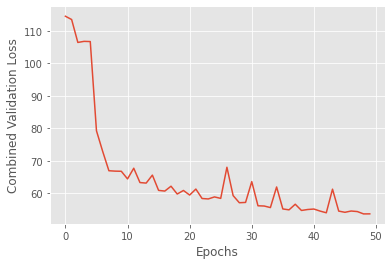

In [ ]:
# Plot total validation loss
fig_val = plt.figure()
plt.plot(x, val_loss)
plt.xlabel("Epochs")
plt.ylabel("Combined Validation Loss")


#Data Prep (Thin)

In [ ]:
# import data from hdf file
fname_mask2 ='/content/drive/MyDrive/Thon Group Master Folder/Sreyas/Photonic Crystals/Rockfish Training Data Gen/allData_thin.h5'
hdf_file2 = h5py.File(fname_mask2, "r")
print(list(hdf_file2.keys()))
tdn=np.shape(hdf_file2["absp"])[0] #total data number
hdn=tdn/2 #half data number

['absp', 'ext_in', 'height', 'height_bin', 'lambda', 'masks', 'refl', 'size_frac', 'tran']


In [ ]:
#Different Dataloader for thin data

class ImageDataset_thin(Dataset):
  #hf is the hdf5 file object
  #datanum is the number of datapoints from EACH set that will be used in the model
    def __init__(self,  hf, datanum, transform= transforms.Compose([ transforms.ToTensor(), transforms.ConvertImageDtype(dtype=torch.float)])  ):
        super(Dataset, self).__init__()

        #Format
        self.masks = np.concatenate((hf['masks'][:datanum],hf['masks'][25000:25000+datanum]), axis=0)  # masks
        self.absp = torch.from_numpy(np.concatenate((hf['absp'][:datanum], hf['absp'][25000:25000+datanum]), axis=0))
        self.refl = torch.from_numpy(np.concatenate((hf['refl'], hf['refl'][25000:25000+datanum]), axis=0))       
        self.tran = torch.from_numpy(np.concatenate((hf['tran'], hf['tran'][25000:25000+datanum]), axis=0))
        self.heights = torch.from_numpy(np.concatenate((hf['height'],hf['height'][250000:25000+datanum]), axis=0)) # heights
        self.height_bin = torch.from_numpy(np.concatenate((hf['height_bin'][:datanum], hf['height_bin'][25000:25000+datanum]), axis=0)) # bins
        self.size_frac =  torch.from_numpy(np.concatenate((hf['size_frac'][:datanum], hf['size_frac'][25000:25000+datanum]), axis=0)) #
        self.label = torch.from_numpy(np.concatenate((hf['ext_in'][:datanum], hf['ext_in'][25000:25000+datanum]), axis=0))
        self.transform = transform

    def __len__(self):
        return len(self.size_frac)

    # currently extracting image, spectra and height 
    def __getitem__(self, idx): 
        image = self.masks[idx,:,:] # input mask image
        absp =  self.absp[idx,:]
        refl = self.refl[idx,:]
        tran = self.tran[idx,:]
        height = self.heights[idx,:]

        if self.transform: 
            image = self.transform(image)
             
        return image, absp, refl, tran, height

In [ ]:
# # DEFINE HYPERPARAMETERS # #
# for defining data
half_data_num = 500 # amount of data to use from EACH int / ext dataset
bsize = 3 # batch size, careful about making bigger because can cause cuda error 

# for defining network
fv = [256, 256, 512, 1024, 2048] #Channels/Convolutions of Images
fv_inv = [1024, 512, 256] #Channels/Tranpose Convolutions of Latent Space
ks = 3 #kernel size
feat_size = 512 #Feature Space Size
latent_features = 20 # dimensionality of latent space

# for defining loss
alpha = 30 #how much to weight MSE loss
beta = 1/40 #how much to weight KLD

# for defining training 
epochs = 50 # number of epochs to train for
# lr = 1e-6 # learning rate of SGD optimizer
lr = 1e-2 # learning rate of SGD optimizer
w_d = 1e-5 # weight decay of SGD optimizer

In [ ]:
# # Data preparation
hf=hdf_file2
datanum=half_data_num
full_dataset2 = ImageDataset_thin(hdf_file2, half_data_num)

# Define ratios of train, validation and testing data
train_size2 = int(0.7 * len(full_dataset2))
val_size2 = int(0.2 * len(full_dataset2))
test_size2 = int(0.1 * len(full_dataset2))

# Use random split with seed
split_seed=42;
print("Split Seed is:", split_seed)
data_train2, data_val2, data_test2 = torch.utils.data.random_split(full_dataset2, [train_size2, val_size2, test_size2], generator=torch.Generator().manual_seed(split_seed))


# Split data into random batches
train_dataloader2 = DataLoader(data_train2, batch_size = bsize, shuffle=True)
test_dataloader2 = DataLoader(data_test2, batch_size = bsize)
valid_dataloader2 = DataLoader(data_val2, batch_size = bsize)

Split Seed is: 42


#Model (Thin)

In [ ]:
#Feature Extraction, Prediction, Recognition
class Encoder_thin(nn.Module):
  def __init__(self, fv, fv_inv, ks, feat_size, spec_points):
    super().__init__()

    self.fv = fv #Feature V=Vectors
    self.fv_inv = fv_inv #Reconstruction Vecotrs
    self.ks = ks #Kernel Size
    self.feat_size = feat_size #Latent Space Size
    self.spec_points = spec_points ## of wavelengths (always 219)

    # Feature Extraction Network 
    self.enc1 = nn.Sequential(
            # Conv_1
            nn.Conv2d(1, fv[0], kernel_size=ks, stride=1, padding="same"),
            nn.BatchNorm2d(fv[0]),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            
            # Conv_2 + Pool_1
            nn.Conv2d(fv[0], fv[1], kernel_size=ks,  stride=1, padding="same"),
            nn.BatchNorm2d(fv[1]),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),     
            nn.MaxPool2d(2,2),

            # Conv_3 + Pool_2
            nn.Conv2d(fv[1], fv[2], kernel_size=ks,  stride=1, padding="same"),
            nn.BatchNorm2d(fv[2]),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.MaxPool2d(2,2),

            # Conv_4 + Pool_3
            nn.Conv2d(fv[2], fv[3], kernel_size=ks,  stride=1, padding="same"),
            nn.BatchNorm2d(fv[3]),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.MaxPool2d(2,2),
        )
    
    #Feature Extraction Network to feature layer
    self.enc2 = nn.Sequential(
            nn.Linear(fv[3]*32*32, feat_size), #Reducing to Feature Size
            nn.BatchNorm1d(feat_size)
        )

    # Prediction network -- Reworked for separate spectra
    self.pred1 = nn.Sequential( 
            nn.Linear(feat_size, feat_size),
            nn.BatchNorm1d(feat_size),
            nn.Linear(feat_size, feat_size),
            nn.BatchNorm1d(feat_size),
            nn.Linear(feat_size, spec_points*3)
        )


    # # Recognition network
    self.rec1 =  nn.Sequential( nn.Linear(feat_size+3*spec_points, feat_size),
                               nn.BatchNorm1d(feat_size),
    )
    self.fc_mean = nn.Linear(feat_size, latent_features)
    self.fc_cov = nn.Linear(feat_size, latent_features)
    
  def forward(self, x):

    # Run Feature Extraction Network
    x = self.enc1(x)
    flat_size = np.prod(x.size()[1:])
    x = x.view(-1, flat_size) 
    x = self.enc2(x)
    
    # Run Prediction Network
    p = torch.sigmoid(self.pred1(x)) # p = predicted spectra

    # Run Recognition Network
    input_rec = torch.cat((x, p), 1) # Combine condensed geometry features with the predicted spectra    
    x = self.rec1(input_rec)
    mu = self.fc_mean(x)
    log_var = self.fc_cov(x)

    return p, mu, log_var

In [ ]:
x = torch.randn(bsize, 1, 256, 256)
net = Encoder_thin(fv, fv_inv, ks, feat_size, spec_points)
p, mu , log_var = net(x)

print(p.shape)
print(mu.shape)
print(log_var.shape)

torch.Size([3, 657])
torch.Size([3, 20])
torch.Size([3, 20])


In [ ]:
class Decoder_thin(nn.Module):
  def __init__(self, fv, fv_inv, ks, feat_size, spec_points):
    super().__init__()
    self.recon1 = nn.Sequential(
          #Fc_4 Fc_5 Fc_6
          nn.Linear(latent_features+3*spec_points, feat_size),
          nn.BatchNorm1d(feat_size),
          nn.Linear(feat_size, feat_size),
          nn.BatchNorm1d(feat_size),
          nn.Linear(feat_size, 32*32*fv_inv[0]),
          nn.BatchNorm1d(32*32*fv_inv[0]),
        )

    self.recon2 = nn.Sequential(
          nn.ConvTranspose2d(fv_inv[0], fv_inv[1], 3, stride=2, padding = 1, output_padding=1),
          nn.ConvTranspose2d(fv_inv[1], fv_inv[2], 3, stride=2, padding = 1, output_padding=1),
          nn.ConvTranspose2d(fv_inv[2], 1, 3, stride=2, padding = 1, output_padding=1)
        )


  def forward(self, spectra, latent):
    x = torch.cat((spectra, latent), 1)
    x = self.recon1(x)
    x = x.view(int(torch.numel(x)/32/32/fv_inv[0]), fv_inv[0], 32, 32)
    x = self.recon2(x)
    reconstruction =  torch.sigmoid(x)
    return reconstruction

In [ ]:
spectra = torch.randn(bsize, 3*spec_points)
latent = torch.randn(bsize, 20)

net = Decoder_thin(fv, fv_inv, ks, feat_size, spec_points)
x = net(spectra, latent)
print(x.shape)

torch.Size([3, 1, 256, 256])


In [ ]:
class CustomVAE_thin(nn.Module):
    def __init__(self, fv, fv_inv, ks, feat_size, spec_points):
        super(CustomVAE_thin, self).__init__()
        self.encoder = Encoder_thin(fv, fv_inv, ks, feat_size, spec_points)
        self.decoder = Decoder_thin(fv, fv_inv, ks, feat_size, spec_points)

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample

    def forward(self, x):
        #Encode       
        spectra, mu, log_var = self.encoder(x)

        #Reparameterize
        sample = self.reparameterize(mu, log_var)

        #Reconstruct
        recon_x = self.decoder(spectra, sample)
        #recon_x = recon_x.view(int(torch.numel(recon_x)/256/256), 256, 256)
        return recon_x

In [ ]:
x = torch.randn(bsize, 1, 256, 256)
net = CustomVAE_thin(fv, fv_inv, ks, feat_size, spec_points)
x = net(x)

print(x.shape)

torch.Size([3, 256, 256])


# Loss, Fit, Validation (Thin)